In [20]:
# !/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Project: 屏蔽社区留言版的侮辱性留言
Project Readme: 构建一个快速过滤器来屏蔽在线社区留言板上的侮辱性言论。
如果某条留言使用了负面或者侮辱性的语言，那么就将该留言标识为内容不当。对
此问题建立两个类别: 侮辱类和非侮辱类，使用 1 和 0 分别表示。
"""
import numpy as np
import operator 
from math import log

#### traning data

In [21]:
def loadDataSet():
    """
    创建数据集
    :return 单词列表postingList 所属类别classVec
    """
    postingList = [['my', 'dog', 'has', 'flea', 'problems', 'help', 'please'], #[0,0,1,1,1......]
                   ['maybe', 'not', 'take', 'him', 'to', 'dog', 'park', 'stupid'],
                   ['my', 'dalmation', 'is', 'so', 'cute', 'I', 'love', 'him'],
                   ['stop', 'posting', 'stupid', 'worthless', 'garbage'],
                   ['mr', 'licks', 'ate', 'my', 'steak', 'how', 'to', 'stop', 'him'],
                   ['quit', 'buying', 'worthless', 'dog', 'food', 'stupid']]
    classVec = [0, 1, 0, 1, 0, 1]  # 1 is abusive, 0 not
    return postingList, classVec

#### 提取文档中所有词条并且去重
#### 从文本中构建词向量

In [22]:
def creatVocablist(dataSet):
    """
    获取所有词汇的集合
    : param dataSet
    : return 所有单词的集合
    """
    vocabSet = set([])
    for word in dataSet:
        vocabSet = vocabSet | set(word)
    return list(vocabSet)
postingList, classVec = loadDataSet()

vocabSet = creatVocablist(postingList)

#### 构建词向量 一维

In [23]:
def setOfWords2Vec(vocabList, inputData):
    """
    变量查看该单词是否出现,若是出现则将该单词置1
    :param vocabList 单词表
    :param inputSet 输入数据集
    :return 返回列表形式的一维数据 [0,1,0,1...]，其中 1与0 表示词汇表中的单词是否出现在输入的数据集中
    """
    n = len(vocabSet)
    returnVec = np.zeros(n)
    for word in inputData:
        if word in vocabSet:
            returnVec[vocabSet.index(word)] = 1
    return returnVec

#### 将postingList 转化为矩阵数据 数据中只包含0或1
#### 编写朴素贝叶斯分类器训练函数

In [24]:
trainMatriX = []
for dataSet in postingList:
    trainMatriX.append(setOfWords2Vec(vocabSet, dataSet))
len(trainMatriX)
len(classVec)


6

### 朴素贝叶斯分类器训练函数 基本原理

#### $p(c_i|w) = \frac{p(w|c_i)p(c_i)}{p(w)}$
#### $w表示向量 由多个值组成$
#### 即核心问题：量化为在向量w发生时 属于$c_i$的概率比较问题
#### 条件概率中 分母是一致的 因此不需要考虑吧
#### 分母表示在属于类别$c_i$时发生，向量$w$发生的概率
#### 这里假设所有词都互相独立，该假设也称作条件独立性假设（例如 A 和 B 两个人抛骰子，概率是互不影响的，也就是相互独立的，A 抛 2点的同时 B 抛 3 点的概率就是 1/6 * 1/6），它意味着可以使用 p(w0 | ci)p(w1 | ci)p(w2 | ci)...p(wn | ci) 来计算上述概率，这样就极大地简化了计算的过程。
#### 问题量化：$在类别c_i发生时,w发生的可能性$
#### 即：$属于侮辱性类别i时,向量w发生的可能性$
#### 引入到向量 $在i类别时,每个单词出现的概率$

In [25]:
def _trainNB0(trainMatriX, classVec):
    numDocuments = len(trainMatriX)
    numWords = len(trainMatriX[0])
    abuseRate = sum(classVec) / len(trainMatriX)
    # 构建单词出现次数列表
    p0Num = np.zeros(numWords)
    p1Num = np.zeros(numWords)
    # 类别i发生时 包含的数据集的单词总数
    p0Denum = 0
    p1Denum = 0
    for i in range(numDocuments):
        # 是否是侮辱性文件
        if classVec[i] == 1:
            # 如果是侮辱性文件，对侮辱性文件的向量进行加和
            p1Num += trainMatriX[i]
            # 对向量中的所有元素进行求和，也就是计算所有侮辱性文件中出现的单词总数
            p1Denum += sum(trainMatriX[i])
        else:
            p0Num += trainMatriX[i]
            p1Denum += sum(trainMatriX[i])
            
    # 类别1下单词发生的概率
    p1Vect = p1Num / p1Denum
    # 类别0
    p0Vect = p0Num / p0Denum
    
    return abuseRate, p1Vect, p0Vect  

#### 根据实际情况修改Naive Bayes classifier

In [26]:
def trainNB0(trainMatriX, classVec):
    numDocu = len(trainMatriX)
    numWords = len(trainMatriX[0])
    abuseRate = sum(classVec) / float(numWords)
    # 构建单词出现次数列表
    p0Num = np.ones(numWords)
    p1Num = np.ones(numWords)
    # 计算单词 在不同类别出现的总次数
    p0Denum = 2.0
    p1Denum = 2.0
    
    for i in range(numDocu):
        if classVec[i] == 1:
            p1Num += trainMatriX[i]
            p1Denum += sum(trainMatriX[i])
        else:
            p0Num += trainMatriX[i]
            p0Denum += sum(trainMatriX[i])
            
    p1Vect = np.log(p1Num / p1Denum)
    p0Vect = np.log(p0Num/ p0Denum)
    return abuseRate, p1Vect, p0Vect

#### 在利用贝叶斯分类器对文档进行分类时，要计算多个概率的乘积以获得文档属于某个类别的概率，即计算 p(w0|1) * p(w1|1) * p(w2|1)。如果其中一个概率值为 0，那么最后的乘积也为 0。为降低这种影响，可以将所有词的出现数初始化为 1，并将分母初始化为 2 （取1 或 2 的目的主要是为了保证分子和分母不为0，大家可以根据业务需求进行更改）。

#### 另一个遇到的问题是下溢出，这是由于太多很小的数相乘造成的。当计算乘积 p(w0|ci) * p(w1|ci) * p(w2|ci)... p(wn|ci) 时，由于大部分因子都非常小，所以程序会下溢出或者得到不正确的答案。（用 Python 尝试相乘许多很小的数，最后四舍五入后会得到 0）。一种解决办法是对乘积取自然对数。在代数中有 ln(a * b) = ln(a) + ln(b), 于是通过求对数可以避免下溢出或者浮点数舍入导致的错误。同时，采用自然对数进行处理不会有任何损失。

#### 下图给出了函数 f(x) 与 ln(f(x)) 的曲线。可以看出，它们在相同区域内同时增加或者减少，并且在相同点上取到极值。它们的取值虽然不同，但不影响最终结果。

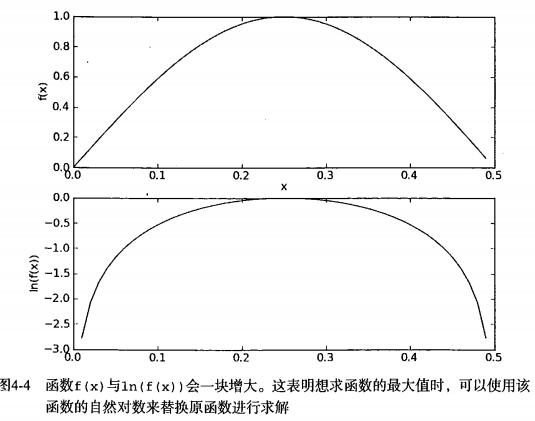

#### 朴素贝叶斯分类函数

In [29]:
def classifyNB(vec2Classify, p0Vec, p1Vec, pClass1):
    """
    使用算法：
    # 将乘法转换为加法
    乘法：P(C|F1F2...Fn) = P(F1F2...Fn|C)P(C)/P(F1F2...Fn)
    加法：P(F1|C)*P(F2|C)....P(Fn|C)P(C) -> log(P(F1|C))+log(P(F2|C))+....+log(P(Fn|C))+log(P(C))
    :param vec2Classify: 待测数据[0,1,1,1,1...]，即要分类的向量
    :param p0Vec: 类别0，即正常文档的[log(P(F1|C0)),log(P(F2|C0)),log(P(F3|C0)),log(P(F4|C0)),log(P(F5|C0))....]列表
    :param p1Vec: 类别1，即侮辱性文档的[log(P(F1|C1)),log(P(F2|C1)),log(P(F3|C1)),log(P(F4|C1)),log(P(F5|C1))....]列表
    :param pClass1: 类别1，侮辱性文件的出现概率
    :return: 类别1 or 0
    """
    # 计算公式  log(P(F1|C))+log(P(F2|C))+....+log(P(Fn|C))+log(P(C))
    # 大家可能会发现，上面的计算公式，没有除以贝叶斯准则的公式的分母，也就是 P(w) （P(w) 指的是此文档在所有的文档中出现的概率）就进行概率大小的比较了，
    # 因为 P(w) 针对的是包含侮辱和非侮辱的全部文档，所以 P(w) 是相同的。
    # 使用 NumPy 数组来计算两个向量相乘的结果，这里的相乘是指对应元素相乘，即先将两个向量中的第一个元素相乘，然后将第2个元素相乘，以此类推。
    # 我的理解是：这里的 vec2Classify * p1Vec 的意思就是将每个词与其对应的概率相关联起来
    p1 = sum(vec2Classify * p1Vec) + log(pClass1)
    print(log(pClass1))
    p0 = sum(vec2Classify * p0Vec) + log(1- pClass1)
    print(p1, p0)
    if p1 > p0:
        return 1
    else:
        return 0

#### 测试朴素贝叶斯算法

In [30]:
def testingNB():
    """
    测试朴素贝叶斯算法
    """
    # 1. 加载数据集
    listOPosts, listClasses = loadDataSet()
    # 2. 创建单词集合
    myVocabList = creatVocablist(listOPosts)
    # 3. 计算单词是否出现并创建数据矩阵
    trainMat = []
    for postinDoc in listOPosts:
        # 返回m*len(myVocabList)的矩阵， 记录的都是0，1信息
        trainMat.append(setOfWords2Vec(myVocabList, postinDoc))
    # 4. 训练数据
    pAb, p1V, p0V = trainNB0(np.array(trainMat), np.array(listClasses))
    # 5. 测试数据
    testEntry = ['love', 'my', 'dalmation']
    thisDoc = np.array(setOfWords2Vec(myVocabList, testEntry))
    print(testEntry, 'classified as: ', classifyNB(thisDoc, p0V, p1V, pAb))
    testEntry = ['stupid', 'garbage']
    thisDoc = np.array(setOfWords2Vec(myVocabList, testEntry))
    print(testEntry, 'classified as: ', classifyNB(thisDoc, p0V, p1V, pAb))
    
if __name__ == '__main__':
    testingNB()

-2.367123614131617
-11.5006909273 -7.10014096464
['love', 'my', 'dalmation'] classified as:  0
-2.367123614131617
-6.3767269479 -6.61463314886
['stupid', 'garbage'] classified as:  1
